This notebook is based on the [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview) competition on Kaggle.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Datasets

## holidays_events.csv

- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [2]:
holidays_events_df = pd.read_csv('datasets/holidays_events.csv', parse_dates=['date'])
holidays_events_df.head(10)

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   
5 2012-05-12  Holiday     Local        Puyo         Cantonizacion del Puyo   
6 2012-06-23  Holiday     Local    Guaranda      Cantonizacion de Guaranda   
7 2012-06-25  Holiday  Regional    Imbabura  Provincializacion de Imbabura   
8 2012-06-25  Holiday     Local   Latacunga     Cantonizacion de Latacunga   
9 2012-06-25  Holiday     Local     Machala           Fundacion de Machala   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  
5        False  
6        False  
7        False  
8        False  
9        False

In [3]:
holidays_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [4]:
holidays_events_df.nunique()

date           312
type             6
locale           3
locale_name     24
description    103
transferred      2
dtype: int64

In [5]:
holidays_events_df.duplicated().sum()

np.int64(0)

## oil.csv

- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [6]:
oil_df = pd.read_csv('datasets/oil.csv', parse_dates=['date'])
print(oil_df.shape)
oil_df.head(10)

(1218, 2)


date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20
5 2013-01-08       93.21
6 2013-01-09       93.08
7 2013-01-10       93.81
8 2013-01-11       93.60
9 2013-01-14       94.27

In [7]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [8]:
oil_df.nunique()

date          1218
dcoilwtico     998
dtype: int64

In [9]:
oil_df.duplicated().sum()

np.int64(0)

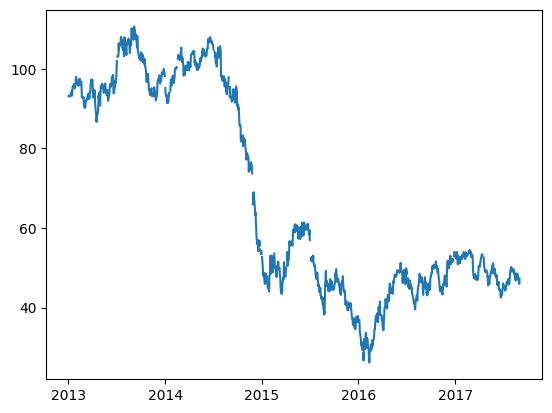

In [10]:
plt.plot(oil_df['date'], oil_df['dcoilwtico'])

## stores.csv


- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

In [11]:
stores_df = pd.read_csv('datasets/stores.csv')
print(stores_df.shape)
stores_df.head()

(54, 5)


store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [12]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [13]:
stores_df.nunique()

store_nbr    54
city         22
state        16
type          5
cluster      17
dtype: int64

In [14]:
stores_df.duplicated().sum()

np.int64(0)

## train.csv

- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

In [15]:
train_df = pd.read_csv('datasets/train.csv', parse_dates=['date'], index_col='id')
train_df

date  store_nbr                      family     sales  \
id                                                                    
0       2013-01-01          1                  AUTOMOTIVE     0.000   
1       2013-01-01          1                   BABY CARE     0.000   
2       2013-01-01          1                      BEAUTY     0.000   
3       2013-01-01          1                   BEVERAGES     0.000   
4       2013-01-01          1                       BOOKS     0.000   
...            ...        ...                         ...       ...   
3000883 2017-08-15          9                     POULTRY   438.133   
3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
id                    
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 5 columns]

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 137.4+ MB


In [17]:
train_df.nunique()

date             1684
store_nbr          54
family             33
sales          379610
onpromotion       362
dtype: int64

In [18]:
train_df.duplicated().sum()

np.int64(0)

In [40]:
sum_stores = train_df.groupby(['date', 'store_nbr'])['sales'].sum().reset_index()
sum_stores

date  store_nbr         sales
0     2013-01-01          1      0.000000
1     2013-01-01          2      0.000000
2     2013-01-01          3      0.000000
3     2013-01-01          4      0.000000
4     2013-01-01          5      0.000000
...          ...        ...           ...
90931 2017-08-15         50  16879.121004
90932 2017-08-15         51  20154.559000
90933 2017-08-15         52  18600.046000
90934 2017-08-15         53   8208.189000
90935 2017-08-15         54  12666.858000

[90936 rows x 3 columns]

In [49]:
px.line(sum_stores, x='date', y='sales', color='store_nbr', width=700)

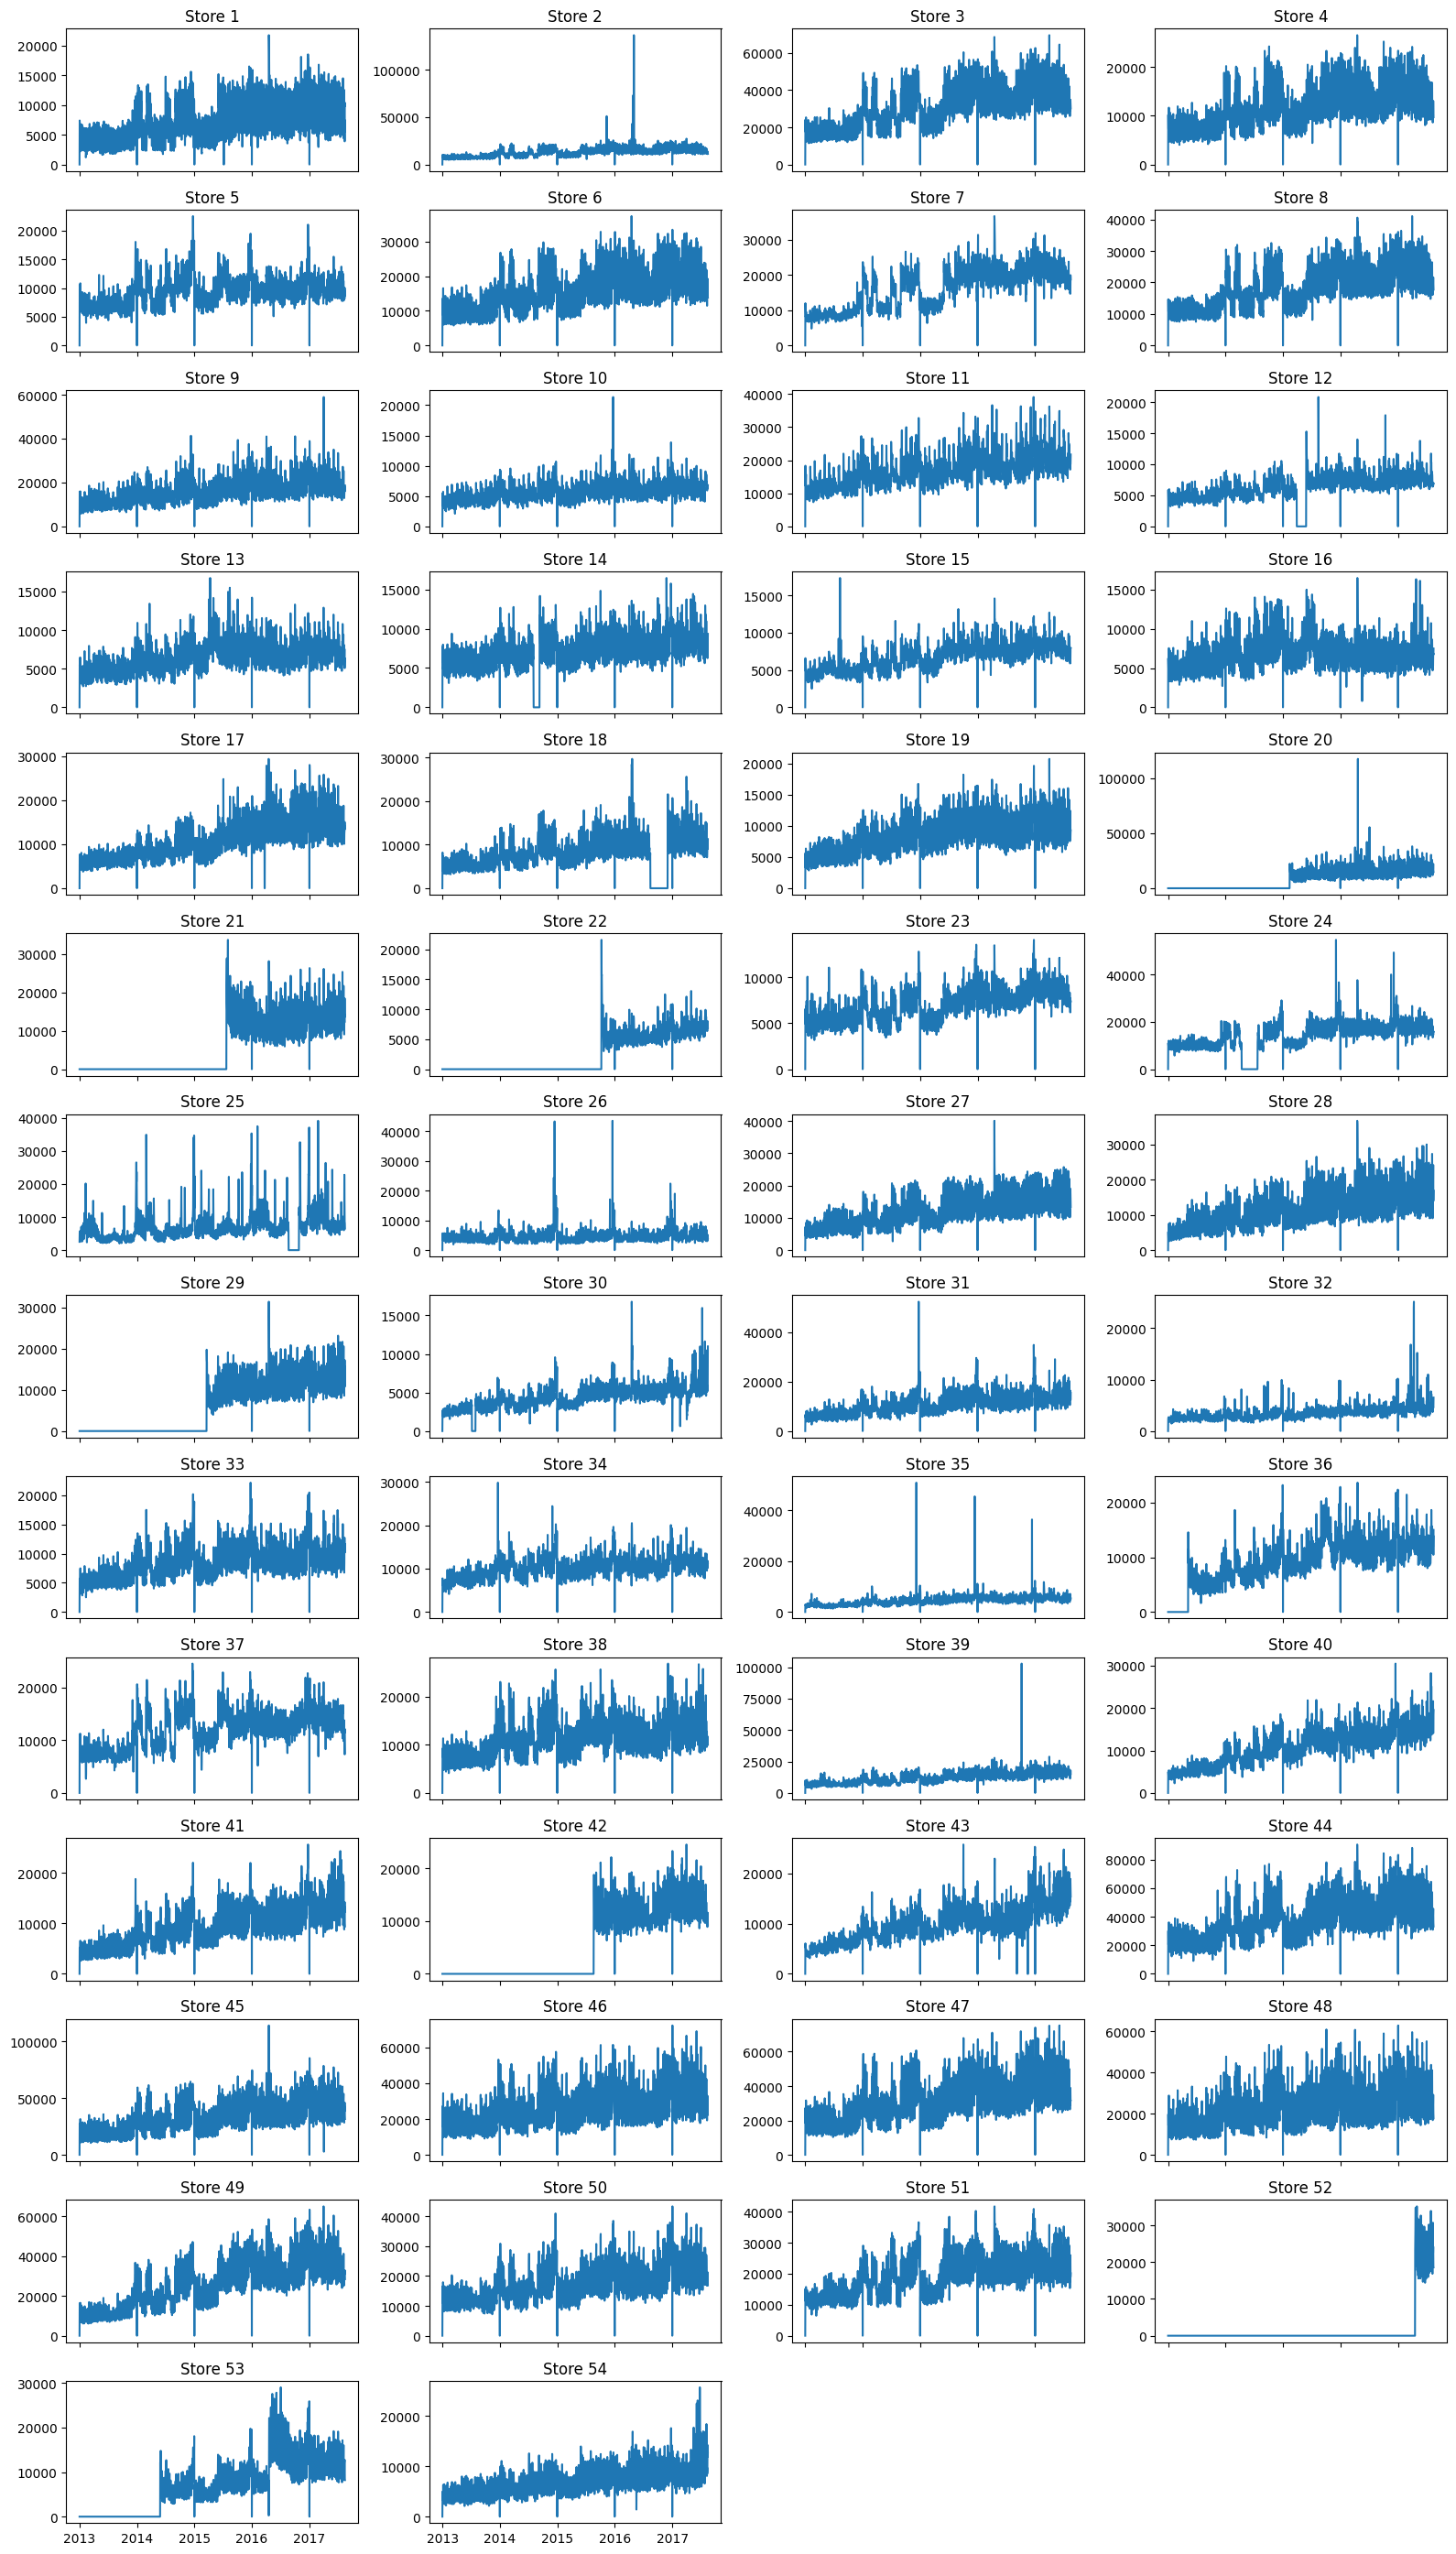

In [62]:
stores_list = sum_stores['store_nbr'].unique()

fig, axes = plt.subplots(nrows=14, ncols=4, figsize=(16, 28), sharex=True)
axes = axes.flatten()

for i, store in enumerate(stores_list):
    store_data = sum_stores[sum_stores['store_nbr'] == store]
    ax = axes[i]
    ax.plot(store_data['date'], store_data['sales'])
    ax.set_title(f'Store {store}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## test.csv

In [19]:
test_df = pd.read_csv('datasets/test.csv', parse_dates=['date'], index_col='id')
test_df

date  store_nbr                      family  onpromotion
id                                                                    
3000888 2017-08-16          1                  AUTOMOTIVE            0
3000889 2017-08-16          1                   BABY CARE            0
3000890 2017-08-16          1                      BEAUTY            2
3000891 2017-08-16          1                   BEVERAGES           20
3000892 2017-08-16          1                       BOOKS            0
...            ...        ...                         ...          ...
3029395 2017-08-31          9                     POULTRY            1
3029396 2017-08-31          9              PREPARED FOODS            0
3029397 2017-08-31          9                     PRODUCE            1
3029398 2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9
3029399 2017-08-31          9                     SEAFOOD            0

[28512 rows x 4 columns]

In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28512 entries, 3000888 to 3029399
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         28512 non-null  datetime64[ns]
 1   store_nbr    28512 non-null  int64         
 2   family       28512 non-null  object        
 3   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.1+ MB


In [21]:
print('Number of unique values:')
print(test_df.nunique())
print('-')
print('Number of duplicated rows:', test_df.duplicated().sum())

Number of unique values:
date            16
store_nbr       54
family          33
onpromotion    212
dtype: int64
-
Number of duplicated rows: 0


## transactions

In [22]:
transactions_df = pd.read_csv('datasets/transactions.csv', parse_dates=['date'])
print(transactions_df.shape)
transactions_df.head()

(83488, 3)


date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922

In [23]:
print(transactions_df.nunique())
transactions_df.info()

date            1682
store_nbr         54
transactions    4993
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


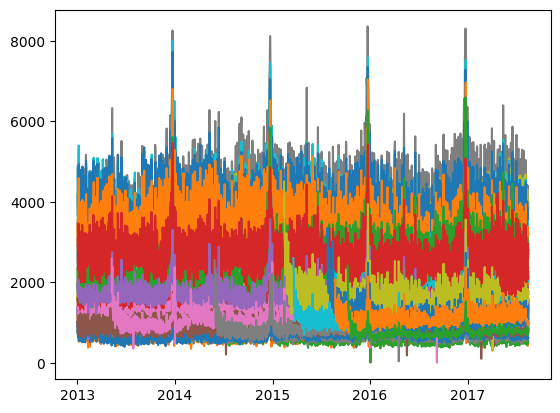

In [24]:
for store_nbr in transactions_df['store_nbr'].unique():
    i_store = transactions_df[transactions_df['store_nbr'] == store_nbr]
    plt.plot(i_store['date'], i_store['transactions'])

In [25]:
dayofweek_transactions = transactions_df.copy()
dayofweek_transactions['dayofweek'] = dayofweek_transactions['date'].dt.dayofweek # data['date'].dt.dayofweek returns 0 for Monday, 1 for Tuesday, ..., 6 for Sunday
dayofweek_transactions['year'] = dayofweek_transactions['date'].dt.year
dayofweek_transactions = dayofweek_transactions.groupby(['dayofweek', 'year']).agg({'transactions': 'mean'}).reset_index()
px.line(dayofweek_transactions, x='dayofweek', y='transactions', color='year', title='Average Transactions by Day of Week and Year', width=600).show()

## transactions + sales data

In [26]:
tr_tr_df = pd.merge(train_df.groupby(["date", "store_nbr"]).sales.sum().reset_index(), transactions_df, how = "left")

In [27]:
px.scatter(tr_tr_df, x = "transactions", y = "sales", width=500)

In [28]:
tr_tr_df

date  store_nbr         sales  transactions
0     2013-01-01          1      0.000000           NaN
1     2013-01-01          2      0.000000           NaN
2     2013-01-01          3      0.000000           NaN
3     2013-01-01          4      0.000000           NaN
4     2013-01-01          5      0.000000           NaN
...          ...        ...           ...           ...
90931 2017-08-15         50  16879.121004        2804.0
90932 2017-08-15         51  20154.559000        1573.0
90933 2017-08-15         52  18600.046000        2255.0
90934 2017-08-15         53   8208.189000         932.0
90935 2017-08-15         54  12666.858000         802.0

[90936 rows x 4 columns]

In [29]:
trtroil_df = pd.merge(tr_tr_df, oil_df, how='left')
trtroil_df

date  store_nbr         sales  transactions  dcoilwtico
0     2013-01-01          1      0.000000           NaN         NaN
1     2013-01-01          2      0.000000           NaN         NaN
2     2013-01-01          3      0.000000           NaN         NaN
3     2013-01-01          4      0.000000           NaN         NaN
4     2013-01-01          5      0.000000           NaN         NaN
...          ...        ...           ...           ...         ...
90931 2017-08-15         50  16879.121004        2804.0       47.57
90932 2017-08-15         51  20154.559000        1573.0       47.57
90933 2017-08-15         52  18600.046000        2255.0       47.57
90934 2017-08-15         53   8208.189000         932.0       47.57
90935 2017-08-15         54  12666.858000         802.0       47.57

[90936 rows x 5 columns]

In [30]:
px.scatter(trtroil_df, x='dcoilwtico', y='sales', width=500)